In [465]:
import numpy as np
import random
import sys
from scipy import stats
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import row
from bokeh.io import output_notebook
import matplotlib.pyplot as plt

output_notebook()

Loading BokehJS ...

In [466]:
rawfile = np.genfromtxt('ps5_line_data.txt') ##Import data from file location
X = rawfile[:,0] ##pressure data
Y = rawfile[:,1] ##density data
Yerr = rawfile[:,2] ##error data

params0 = [2,9] ## insert initial guess for slope and intercept

stepsize =  0.015 ## insert reasonable values for the step size in each parameter

n_steps = 10000 ## insert number of steps to run the MCMC

In [467]:
def get_model(params,x): ##evaluate the y-values of the model, given the current guess of parameter values
    slope = params[0]
    intcep = params[1]
    model = slope*x+intcep##insert equation for your model to calculate y-values
    
    return model

In [468]:
def get_log_likelihood(params, x, y, error): ##obtain the chi2 value of the model y-values given current parameters vs. the measured y-values
    
    ##calculate chi2
    chi2 = np.sum(np.power(((get_model(params,x) - y)/error), 2))
    return chi2

In [469]:
def perturb_pick(param): ##select a model parameter to perturb
    
    ##this function randomly selects which model parameter to perturb based on how many parameters are in the model
    picker = (np.random.choice(param,1))[0]
    
    return picker

In [470]:
def propose_param(active_param, stepsize, perturb_value): 

    ##obtain a trial model parameter for the current step
    curr_param = active_param[:]
    param_idx = 0
    for i in range(len(active_param)):
        if perturb_value == active_param[i]:
            param_idx = i
            
    curr_param[param_idx] = perturb_value+np.random.uniform(-stepsize,stepsize)
    try_param = curr_param
    
    return try_param

In [471]:
def step_eval(params, stepsize, x, y, error, perturb_value): ##evaluate whether to step to the new trial value
    
    chi2_old = get_log_likelihood(params, x, y, error) ##the chi2 value of the parameters from the previous step
    
    try_param = propose_param(params, stepsize, perturb_value) ## read in the trial model parameters for the current step

    chi2_try = get_log_likelihood(try_param, x, y, error) ## the chi2 value of the trial model parameters for the current step
    
    acceptvalue = [None]*len(params)
    
    param_idx = sys.maxsize
        
    #insert some if/else statements her to determine whether a step should be taken
    
    for i in range(len(params)):
        if perturb_value == params[i]:
            param_idx = i
            
    alph = np.exp(chi2_old-chi2_try)
    #if np.random.uniform(0,1) < alph:
    #    new_param = try_param
    #    acceptvalue[param_idx] = 1
    #else:
    #    new_param = params
    #    acceptvalue[param_idx] = 0
    
    if chi2_try < chi2_old:
        new_param = try_param
        acceptvalue[param_idx] = 1 
        # print("in try > old; accept")
    else:
        if np.random.uniform(0,1) <= alph:
            new_param = try_param
            acceptvalue[param_idx] = 1
        else:
            new_param = params
            acceptvalue[param_idx] = 0
        #new_param = params
        #acceptvalue[param_idx] =0 
        #if (np.random.choice([1,0], 1, p=[(chi2_old/chi2_try), (1-(chi2_old/chi2_try))]))[0] == 1:
        #    new_param = try_param
        #    acceptvalue[param_idx] = 1
            # print("in try < old; accept")
        #else:
        #    new_param = params
        #    acceptvalue[param_idx] = 0
            # print("in try < old; reject")
    return new_param, acceptvalue

In [472]:
def MCMC(params, stepsize, x, y, error, n_steps): ##run the whole MCMC routine, calling the subroutines written above
    chain = []
    accept_chain = []
    chi2_chain = []
    param = params[:]
    
    for i in range(n_steps):
        perturb_value = perturb_pick(param)
        stepRes = step_eval(param, stepsize, x, y, error, perturb_value)
        param = stepRes[0]
        chain.append(stepRes[0])
        accept_chain.append(stepRes[1])
        chi2_chain.append(get_log_likelihood(stepRes[0], x, y, error))
    
    chain = np.array(chain)
    accept_chain = np.array(accept_chain)
    chi2_chain = np.array(chi2_chain)
    return chain, accept_chain, chi2_chain

In [473]:
chain, accept_chain, chi2_chain = MCMC(params0, stepsize, X, Y, Yerr, n_steps) ##run the MCMC and output the chains

/Users/mayafuller/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


In [474]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [475]:
chainChi = np.concatenate((chain,(np.array([chi2_chain])).T),axis=1)
chainChiSort = chainChi[chainChi[:,-1].argsort()]
chainSort = (chainChiSort.T[:2]).T
confPairs = chainSort[:(int(len(chainSort)*(.68)))]

slopeConfMin = np.amin(confPairs[:,0])
slopeConfMax = np.amax(confPairs[:,0])

intConfMin = np.amin(confPairs[:,1])
intConfMax = np.amax(confPairs[:,1])

print("The slope 68% confidence interval is [{}, {}]".format(slopeConfMin, slopeConfMax))
print("The intercept 68% confidence interval is [{}, {}]".format(intConfMin, intConfMax))

The slope 68% confidence interval is [2.5152593136967503, 2.550077521927557]
The intercept 68% confidence interval is [9.69635138419977, 9.94991261423817]


In [476]:
meanSlope = np.mean(chain[:,0])
meanInt = np.mean(chain[:,1])
print("Mean slope is {} and the mean intercept is {}".format(meanSlope,meanInt))

Mean slope is 2.5298486682986137 and the mean intercept is 9.761309257605745


In [477]:
traceSlope = figure(
   tools="pan,box_zoom,reset,save", title="Slope Trace Plot",
   x_axis_label='Step Number', y_axis_label='Slope'
)

traceSlope.circle(np.linspace(1,n_steps,num = n_steps),chain[:,0])

show(traceSlope)

slopeAcceptRate = ((np.count_nonzero(accept_chain[:,0] == 1))/(len(accept_chain)))*100

print("Acceptance ratio: {}%".format(slopeAcceptRate))

Acceptance ratio: 17.83%


In [478]:
traceInt = figure(
   tools="pan,box_zoom,reset,save", title="Intercept Trace Plot",
   x_axis_label='Step Number', y_axis_label='Intercept'
)

traceInt.circle(np.linspace(1,n_steps,num = n_steps),chain[:,1])

show(traceInt)

intAcceptRate = ((np.count_nonzero(accept_chain[:,1] == 1))/(len(accept_chain)))*100

print("Acceptance ratio: {}%".format(intAcceptRate))

Acceptance ratio: 43.5%


In [1]:
weightsSlope = np.ones_like(chain[:,0])/float(len(chain[:,0]))
plt.hist(chain[:,0], 50,weights=weightsSlope)
plt.show()
plt.savefig('c_slopeHist.png')

NameError: name 'np' is not defined

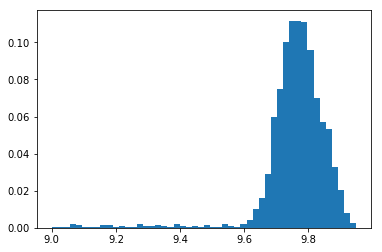

In [480]:
weightsInt = np.ones_like(chain[:,1])/float(len(chain[:,1]))
plt.hist(chain[:,1], 50,weights=weightsInt)
plt.show()
plt.savefig('c_intHist.png')

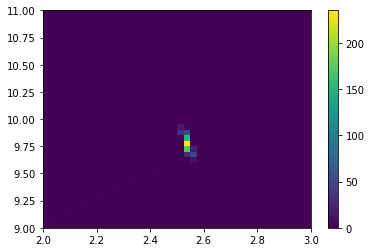

In [481]:
plt.hist2d(chain[:,0], chain[:,1], bins=40,range=[[2,3],[9,11]],normed=True)
plt.colorbar()
plt.show()
plt.savefig('d_2DHist.png')

In [486]:
xMod = np.linspace(4,11,1000)

bestFit = figure(
   tools="pan,box_zoom,reset,save", title="Best Fit",
   x_axis_label='Pressure', y_axis_label='Density'
)

bestFit.line(xMod,get_model([meanSlope,meanInt], xMod),color='black',line_width=2)
bestFit.circle(X,Y,color='green')

show(bestFit)

In [482]:
badParams = [1,4] ## insert initial guess for slope and intercept

badstepsize1 =  0.5 ## insert reasonable values for the step size in each parameter

badn_steps = 10000 ## insert number of steps to run the MCMC

badchain1, badaccept_chain1, badchi2_chain1 = MCMC(badParams, badstepsize1, X, Y, Yerr, badn_steps) ##run the MCMC and output the chains

badtraceSlope1 = figure(
   tools="pan,box_zoom,reset,save", title="Slope Trace Plot",
   x_axis_label='Step Number', y_axis_label='Slope'
)

badtraceSlope1.circle(np.linspace(1,badn_steps,num = badn_steps),badchain1[:,0])

badtraceInt1 = figure(
   tools="pan,box_zoom,reset,save", title="Intercept Trace Plot",
   x_axis_label='Step Number', y_axis_label='Intercept'
)

badtraceInt1.circle(np.linspace(1,badn_steps,num = badn_steps),badchain1[:,1])

show(row(badtraceSlope1,badtraceInt1))

badslopeAcceptRate1 = ((np.count_nonzero(badaccept_chain1[:,0] == 1))/(len(badaccept_chain1)))*100
badintAcceptRate1 = ((np.count_nonzero(badaccept_chain1[:,1] == 1))/(len(badaccept_chain1)))*100

print("Acceptance ratio for slope: {}%".format(badslopeAcceptRate1))
print("Acceptance ratio for intercept: {}%".format(badintAcceptRate1))

/Users/mayafuller/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


Acceptance ratio for slope: 0.74%
Acceptance ratio for intercept: 4.51%


In [483]:
badstepsize2 =  1 ## insert reasonable values for the step size in each parameter

badchain2, badaccept_chain2, badchi2_chain2 = MCMC(badParams, badstepsize2, X, Y, Yerr, badn_steps) ##run the MCMC and output the chains

badtraceSlope2 = figure(
   tools="pan,box_zoom,reset,save", title="Slope Trace Plot",
   x_axis_label='Step Number', y_axis_label='Slope'
)

badtraceSlope2.circle(np.linspace(1,badn_steps,num = badn_steps),badchain2[:,0])

badtraceInt2 = figure(
   tools="pan,box_zoom,reset,save", title="Intercept Trace Plot",
   x_axis_label='Step Number', y_axis_label='Intercept'
)

badtraceInt2.circle(np.linspace(1,badn_steps,num = badn_steps),badchain2[:,1])

show(row(badtraceSlope2,badtraceInt2))

badslopeAcceptRate2= ((np.count_nonzero(badaccept_chain2[:,0] == 1))/(len(badaccept_chain2)))*100
badintAcceptRate2= ((np.count_nonzero(badaccept_chain2[:,1] == 1))/(len(badaccept_chain2)))*100

print("Acceptance ratio for slope: {}%".format(badslopeAcceptRate2))
print("Acceptance ratio for intercept: {}%".format(badintAcceptRate2))

/Users/mayafuller/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


Acceptance ratio for slope: 0.51%
Acceptance ratio for intercept: 2.64%


In [484]:
#Burn-in

#Step size 0.5
burn05guessSlope = 4800
burn05guessInt = 6000
lnL05Med = np.median(badchi2_chain1)
burn05 = np.argmax(badchi2_chain1<lnL05Med)
print(burn05)

#Step size 1
burn1guessSlope = 4800
burn1guessInt = 6000
lnL1Med = np.median(badchi2_chain2)
burn1 = np.argmax(badchi2_chain2<lnL1Med)
print(burn1)




3931
5032
